# import modules

In [1481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
import os
from datetime import datetime, timedelta
import datetime as dt
import missingno as msn
# import calendar

from functools import partial #데이터프레임에서 다중 컬럼을 이용하여 map or apply 사용을 위해 함수 조건 적용
from dateutil.relativedelta import relativedelta # sql add_month와 유사 역할
plt.style.use("seaborn-darkgrid")
plt.rc("font",family = "Malgun Gothic")
plt.rc("axes",unicode_minus = False)

warnings.filterwarnings(action = "ignore")
pd.options.display.max_rows=100
pd.options.display.max_columns = 100

# load files

In [1482]:
next(os.walk("./data"))
# import os;os.listdir('./data')

('./data',
 ['.ipynb_checkpoints'],
 ['NATIONAL REPORT ON E-COMMERCE.pdf',
  'olist_closed_deals_dataset.csv',
  'olist_customers_dataset.csv',
  'olist_geolocation_dataset.csv',
  'olist_marketing_qualified_leads_dataset.csv',
  'olist_orders_dataset.csv',
  'olist_order_items_dataset.csv',
  'olist_order_payments_dataset.csv',
  'olist_order_reviews_dataset.csv',
  'olist_order_reviews_dataset_translate.csv',
  'olist_products_dataset.csv',
  'olist_sellers_dataset.csv',
  'product_category_name_translation.csv'])

In [1483]:
product_category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
olist_products = pd.read_csv("./data/olist_products_dataset.csv")
olist_order_items = pd.read_csv("./data/olist_order_items_dataset.csv")
olist_sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
olist_orders = pd.read_csv("./data/olist_orders_dataset.csv")
olist_customers = pd.read_csv("./data/olist_customers_dataset.csv")
olist_order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv("./data/olist_order_reviews_dataset_translate.csv")
olist_geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")

# 데이터셋별 전처리

## olist_products + product_category_name_translation
**포르투갈어로 되어 있는 상품명을 영문으로 변환**

In [1484]:
olist_products_replace_cat_name = olist_products.copy()

#상품명 통일
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^portateis")==True,"product_category_name"] = "portateis_casa_forno_e_cafe"
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^pc")==True,"product_category_name"] = "pcs"

#상품명 영어로 변환
olist_products_eng = pd.merge(olist_products_replace_cat_name, product_category_name_translation, on = "product_category_name", how = "left")

## category_name 중분류로 대체

In [1485]:
#상품 상위 분류 컬럼 생성
category_rename = {"cool_stuff":"stationery",
"pet_shop":"pet",
"furniture_decor":"furniture",
"perfumery":"beauty",
"garden_tools":"garden_tools",
"housewares":"home_appliances",
"telephony":"telephone",
"health_beauty":"beauty",
"books_technical":"book",
"fashion_bags_accessories":"fashion",
"bed_bath_table":"home_living",
"sports_leisure":"sports",
"consoles_games":"games",
"office_furniture":"furniture",
"luggage_accessories":"stationery",
"food":"food_drink",
"agro_industry_and_commerce":"agro",
"electronics":"electronics",
"computers_accessories":"electronics",
"construction_tools_construction":"construction",
"audio":"electronics",
"baby":"baby",
"construction_tools_lights":"construction",
"toys":"stationery",
"stationery":"stationery",
"industry_commerce_and_business":"others",
"watches_gifts":"stationery",
"auto":"auto",
"home_appliances":"home_appliances",
"kitchen_dining_laundry_garden_furniture":"home_living",
"air_conditioning":"electronics",
"home_confort":"home_living",
"fixed_telephony":"telephone",
"small_appliances_home_oven_and_coffee":"home_appliances",
"diapers_and_hygiene":"home_living",
"signaling_and_security":"security",
"musical_instruments":"culture",
"small_appliances":"home_appliances",
"costruction_tools_garden":"garden_tools",
"art":"culture",
"home_construction":"construction",
"books_general_interest":"book",
"party_supplies":"stationery",
"construction_tools_safety":"construction",
"cine_photo":"culture",
"fashion_underwear_beach":"fashion",
"food_drink":"food_drink",
"drinks":"food_drink",
"furniture_living_room":"furniture",
"market_place":"others",
"music":"culture",
"fashion_shoes":"fashion",
"flowers":"agro",
"home_appliances_2":"home_appliances",
"fashio_female_clothing":"fashion",
"fashion_male_clothing":"fashion",
"computers":"electronics",
"books_imported":"book",
"christmas_supplies":"stationery",
"furniture_bedroom":"furniture",
"home_comfort_2":"home_living",
"dvds_blu_ray":"culture",
"cds_dvds_musicals":"culture",
"arts_and_craftmanship":"culture",
"furniture_mattress_and_upholstery":"furniture",
"tablets_printing_image":"electronics",
"costruction_tools_tools":"construction",
"fashion_sport":"fashion",
"la_cuisine":"food_drink",
"security_and_services":"security",
"fashion_childrens_clothes":"fashion"}

#rename df 생성
df_cat_rename = pd.DataFrame({"product_category_name_english" : category_rename.keys(), "product_category_upper" : category_rename.values()})

#기존 dataset에 중분류 합치기
olist_products_rename = olist_products_eng.merge(df_cat_rename,on = "product_category_name_english", how = "left")

In [1486]:
olist_products_rename.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty


## olist_order_items :  total_payment 컬럼 생성
**olist_order_payments에 payment_value(상품가격 + 배송비)가 있으나,  
해당 컬럼 값이 문제가 없는지 확인하기 위한 용도로 직접 상품가격 + 배송비를 계산하여 컬럼으로 생성**

In [1487]:
olist_order_items["total_payment"] = olist_order_items["price"]+olist_order_items["freight_value"]
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


## olist_order_items : order_id별 상품명 및 판매자 중복 행 합치기
**한 구매 건수(order_id)에 동일한 상품이 여러 개의 관측치로 나눠져 있는 경우 하나로 합치고,
상품별 개수를 따로 지정**

In [1488]:
olist_order_items[olist_order_items.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment
89007,ca3625898fbd48669d50701aba51cd5f,1,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84,310.84
89008,ca3625898fbd48669d50701aba51cd5f,2,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84,35.74
89009,ca3625898fbd48669d50701aba51cd5f,3,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89010,ca3625898fbd48669d50701aba51cd5f,4,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89011,ca3625898fbd48669d50701aba51cd5f,5,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89012,ca3625898fbd48669d50701aba51cd5f,6,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15,110.05
89013,ca3625898fbd48669d50701aba51cd5f,7,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89014,ca3625898fbd48669d50701aba51cd5f,8,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15,63.85
89015,ca3625898fbd48669d50701aba51cd5f,9,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68
89016,ca3625898fbd48669d50701aba51cd5f,10,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68


In [1489]:
olist_order_items_temp = olist_order_items.groupby(["order_id","product_id","seller_id"])\
.agg({"order_item_id" : "count", "total_payment" : "sum", "freight_value" : "sum"})\
.reset_index().rename(columns = {"order_item_id" : "item_nb"})
olist_order_items_temp[olist_order_items_temp.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,product_id,seller_id,item_nb,total_payment,freight_value
80867,ca3625898fbd48669d50701aba51cd5f,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,1,35.74,1.84
80868,ca3625898fbd48669d50701aba51cd5f,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2,325.34,7.34
80869,ca3625898fbd48669d50701aba51cd5f,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,1,310.84,1.84
80870,ca3625898fbd48669d50701aba51cd5f,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,1,63.85,0.15
80871,ca3625898fbd48669d50701aba51cd5f,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2,119.36,7.36
80872,ca3625898fbd48669d50701aba51cd5f,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,1,110.05,0.15
80873,ca3625898fbd48669d50701aba51cd5f,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,1,96.05,0.15
80874,ca3625898fbd48669d50701aba51cd5f,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,1,96.05,0.15


## olist_order_items : freight_value_rate 컬럼 생성
**판매액 중 배송비 비율 컬럼 생성**

In [1490]:
olist_order_items["freight_value_rate"] = olist_order_items["freight_value"] / olist_order_items["total_payment"]
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment,freight_value_rate
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19,0.184098
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83,0.076704
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87,0.082400
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78,0.496121
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04,0.083196


## olist_order_payments : order_id별 payment_value만 남기고 모두 삭제
**해당 데이터셋에선 payment_value와 order_id 컬럼만 사용할 예정이므로, order_id 기준으로 데이터 집계**

In [1491]:
olist_order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [1492]:
olist_order_payments_temp = olist_order_payments.groupby("order_id").payment_value.sum().reset_index().copy()
olist_order_payments_temp.head(1)

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19


## olist_order_reviews : 데이터 확인
**특정 구매 건(order_id)의 경우 review가 여러 개 달린 게 있는데, 이 부분은 전체 dataset을 merge 후 구매 건마다 review가 2개 이상인 경우 제거**

In [1493]:
olist_order_reviews.order_id.value_counts().reset_index().head(10)

,index,order_id
0,8e17072ec97ce29f0e1f111e598b0c85,3
1,df56136b8031ecd28e200bb18e6ddb2e,3
2,03c939fd7fd3b38f8485a0f95798f1f6,3
3,c88b1d1b157a9999ce368f218a407141,3
4,543933b39ebd50e13884fca2829ccdf8,2
5,7845a2492ab1b4f2cf3d56c7b8da1446,2
6,6f118f6a730ce35b230974f295f743f9,2
7,66f943fd426ac8716ef6b6b97ace8bd8,2
8,b8fdf0a70040d5461adca8f95ba4171a,2
9,013056cfe49763c6f66bda03396c5ee3,2


In [1494]:
olist_order_reviews[olist_order_reviews.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en
8329,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 0:00,2018-03-21 2:28,A negative point I found was the collection of...
51931,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 0:00,2018-03-30 0:29,NaN
70005,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 0:00,2018-03-06 19:50,It would be great if they had delivered the 3 ...


In [1495]:
olist_orders[olist_orders.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]
# olist_order_items[olist_order_items.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
12362,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02 00:00:00


## Olist_geolocation

### geolocation_state 이상치 처리
---
실제 zipcode의 state와 다른 state로 작성된 부분 수정

In [1496]:
#zipcode별로 state 개수 확인
zip_code = olist_geolocation[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates()\
.groupby(["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62010,1
2,62000,1
3,61979,1
4,61962,1
...,...,...
19010,79750,2
19011,2116,2
19012,80630,2
19013,4011,2


In [1497]:
#zipcode별 state가 2개인 데이터셋 
zipcode = zip_code[zip_code.geolocation_state>1].geolocation_zip_code_prefix.tolist()
zipcode

[23056, 78557, 21550, 79750, 2116, 80630, 4011, 72915]

In [1498]:
for loc in zipcode:
    #zipcode별 state명 빈도수가 많은 이름 state 선택
    set_states = olist_geolocation[olist_geolocation.geolocation_zip_code_prefix==loc]\
    .groupby("geolocation_state").geolocation_zip_code_prefix.count().sort_values().index[-1]
    
    #zipcode별 state 통일
    olist_geolocation.loc[olist_geolocation.geolocation_zip_code_prefix==loc,"geolocation_state"] = set_states

In [1499]:
zip_code = olist_geolocation[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates()\
.groupby(["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62014,1
2,62011,1
3,62010,1
4,62000,1
...,...,...
19010,19908,1
19011,19907,1
19012,19906,1
19013,19904,1


### zipcode, city, state로 groupby하여 lat,lng의 중간 위치 구하기
**geolocation_zip_code별로 하나의 위경도 값만 남기기 위해 zip_code 기준으로 groupby**

In [1500]:
olist_geolocation.sort_values("geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
...,...,...,...,...,...
1000026,99980,-28.388679,-51.848863,david canabarro,RS
999950,99980,-28.388400,-51.845225,david canabarro,RS
1000002,99980,-28.388342,-51.845194,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


In [1501]:
# olist_geolocation["geolocation_zip_code_prefix"]=olist_geolocation.geolocation_zip_code_prefix.astype(str)
olist_geolocation_mean = olist_geolocation.groupby(["geolocation_zip_code_prefix","geolocation_state"])\
                         [["geolocation_lat","geolocation_lng"]].mean().reset_index()
olist_geolocation_mean.head(2)

,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng
0,1001,SP,-23.550190,-46.634024
1,1002,SP,-23.548146,-46.634979


# merge all

**1-1. olist_products_eng = olist_products_replace_cat_name + product_category_name_translation  
1-2. olist_products_rename = olist_products_eng + 중분류  
2. temp0 = olist_order_items + olist_products_rename  
3-1. olist_sellers_geo = olist_sellers + olist_geolocation  
3-2. temp1 = olist_sellers_geo + olist_order_items  
4. temp2 = temp1 + olist_orders  
5-1. olist_customers_geo = olist_customer + olist_geolocation  
5-2. temp3 = temp2 + olist_customers_geo  
6. temp4 = temp3 + olist_order_payments  
7. temp5 = temp4 + olist_order_reviews_mean**

In [1502]:
olist_sellers_geo = pd.merge(olist_sellers,olist_geolocation_mean,left_on = ["seller_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

olist_customers_geo = pd.merge(olist_customers,olist_geolocation_mean,left_on = ["customer_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

temp0 = pd.merge(olist_order_items_temp,olist_products_rename,on="product_id",how="outer")

temp1 = pd.merge(temp0,olist_sellers_geo,on="seller_id",how="outer")
temp1 = temp1.drop(["seller_city","seller_state","seller_zip_code_prefix"],axis=1)
temp1 = temp1.rename(columns = {'geolocation_zip_code_prefix' : "seller_zip_code_prefix",
                                'geolocation_state' : 'seller_state'})

temp2 = pd.merge(temp1,olist_orders,on = "order_id",how = "outer")

temp3 = pd.merge(temp2,olist_customers_geo,on = "customer_id",how = "outer")
temp3 = temp3.drop(["customer_city","customer_state","customer_zip_code_prefix"],axis=1)
temp3 = temp3.rename(columns = {'geolocation_zip_code_prefix' : "customer_zip_code_prefix",
                                'geolocation_state' : 'customer_state'})

temp4 = pd.merge(temp3,olist_order_payments_temp,on = "order_id",how = "outer")

temp5 = pd.merge(temp4,olist_order_reviews,on = "order_id",how = "outer")

df = temp5.copy()
df.head(2)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,72.19,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed."
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,73.86,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi..."


# 결합 후 전처리

## 컬럼 데이터 타입 변경

In [1503]:
cols = ["order_purchase_timestamp","order_delivered_carrier_date","order_delivered_customer_date",
        "order_estimated_delivery_date"]
df[cols] = df[cols].apply(lambda x : pd.to_datetime(x))

In [1504]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103813 entries, 0 to 103812
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103813 non-null  object        
 1   product_id                     103035 non-null  object        
 2   seller_id                      103035 non-null  object        
 3   item_nb                        103035 non-null  float64       
 4   total_payment                  103035 non-null  float64       
 5   freight_value                  103035 non-null  float64       
 6   product_category_name          101566 non-null  object        
 7   product_name_lenght            101566 non-null  float64       
 8   product_description_lenght     101566 non-null  float64       
 9   product_photos_qty             101566 non-null  float64       
 10  product_weight_g               103019 non-null  float64       
 11  

## 년월 컬럼 생성

In [1505]:
df["year_month"] = df.order_purchase_timestamp.map(lambda x : dt.datetime(x.year, x.month,1)).dt.date
df.head(3)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,year_month
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,72.19,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed.",2017-09-01
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,73.86,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi...",2017-06-01
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,83.23,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,30720.0,MG,-19.914323,-43.975703,83.23,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 0:00,2018-06-06 21:41,very beautiful cart,2018-05-01


## 이상치 처리

### order_id별 review 개수가 2개 이상인 경우 제거
**특정 order_id에서 review 개수가 2개 이상인데, 이 경우 단순히 점수를 올리기 위해서 발생한 경우도 있고,
실제로 판매자가 특정 상황이 발생하여 대처 전후에 대해 review를 한 경우가 있으나,
모든 경우를 고려하기가 불가하여 해당 order_id 제거**

In [1506]:
OrderId_ReviewId = olist_order_reviews.groupby("order_id").review_id.agg("nunique").reset_index()
order_id_list = OrderId_ReviewId[OrderId_ReviewId.review_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]

### order_id별 seller가 2명 이상인 경우 제거
**각 order_id별로 review_score가 정해지는데, seller가 두명 이상인 경우 사항으로 점수가 기입됐는지 확인이 불가**

In [1507]:
OrderID_SellerID = df.groupby("order_id").seller_id.nunique().reset_index()
order_id_list = OrderID_SellerID[OrderID_SellerID.seller_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]

### review_id별 order_id가 2개 이상인 경우 제거

In [1508]:
review_id_list = df.groupby("review_id").order_id.nunique().sort_values().to_frame()
error_review_list = review_id_list[review_id_list.order_id > 1].index.tolist()
df = df[~df.review_id.isin(error_review_list)].copy()

### 구매 시점이 결제 승인, 상품 준비, 배송완료일, 배송완료 예정일 보다 늦은 판매건 제거

In [1509]:
print(f" order_purchase_timestamp > order_approved_at : {len(df[df.order_purchase_timestamp > df.order_approved_at])}")
print(f" order_purchase_timestamp > order_delivered_customer_date : {len(df[df.order_purchase_timestamp > df.order_delivered_customer_date])}")
print(f" order_purchase_timestamp > order_delivered_carrier_date : {len(df[df.order_purchase_timestamp > df.order_delivered_carrier_date])}")
print(f" order_purchase_timestamp > order_estimated_delivery_date : {len(df[df.order_purchase_timestamp > df.order_estimated_delivery_date])}")

 order_purchase_timestamp > order_approved_at : 0
 order_purchase_timestamp > order_delivered_customer_date : 0
 order_purchase_timestamp > order_delivered_carrier_date : 164
 order_purchase_timestamp > order_estimated_delivery_date : 0


In [1510]:
df = df[(df.order_purchase_timestamp <= df.order_delivered_carrier_date)|(df.order_delivered_carrier_date.isnull())]

## 결측치 처리

In [1511]:
null_sum = df.isnull().sum().sort_values(ascending=False).to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df.isnull().mean()*100).sort_values(ascending=False).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(98979, 41)


,review_comment_title,review_comment_msg_en,review_comment_message,order_delivered_customer_date,product_category_name_english,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_upper,order_delivered_carrier_date,geolocation_lng_x,geolocation_lat_x,seller_zip_code_prefix,seller_state,product_width_cm,product_height_cm,product_length_cm,product_weight_g,seller_id,item_nb,total_payment,freight_value,product_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,order_approved_at,payment_value
null(nb),87431.00,57699.00,57672.00,2897.00,2124.00,2124.00,2124.00,2124.00,2124.00,2124.00,1723.00,928.00,928.00,928.00,928.00,731.00,731.00,731.00,731.00,715.00,715.00,715.00,715.00,715.00,273.00,273.00,273.00,273.00,109.00,1.0
null(%),88.33,58.29,58.27,2.93,2.15,2.15,2.15,2.15,2.15,2.15,1.74,0.94,0.94,0.94,0.94,0.74,0.74,0.74,0.74,0.72,0.72,0.72,0.72,0.72,0.28,0.28,0.28,0.28,0.11,0.0


### product_category_name이 결측치인 관측치 제거

In [1512]:
df_temp = df[df.product_category_name.notnull()==True].copy()

null_sum = df_temp.isnull().sum().sort_values(ascending=False).to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df_temp.isnull().mean()*100).sort_values(ascending=False).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df_temp.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(96855, 41)


,review_comment_title,review_comment_msg_en,review_comment_message,order_delivered_customer_date,order_delivered_carrier_date,geolocation_lng_y,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_x,geolocation_lat_x,seller_state,seller_zip_code_prefix,order_approved_at,product_width_cm,product_height_cm,product_length_cm,product_weight_g,payment_value
null(nb),85434.00,56689.00,56662.0,2125.00,977.00,263.00,263.00,263.00,263.00,212.00,212.00,212.00,212.00,13.00,1.0,1.0,1.0,1.0,1.0
null(%),88.21,58.53,58.5,2.19,1.01,0.27,0.27,0.27,0.27,0.22,0.22,0.22,0.22,0.01,0.0,0.0,0.0,0.0,0.0


### order_delivered_customer_date 결측치 확인
***
- 배송이 완료되지 않았거나, 배송 취소, 배송 불가로 인한 배송완료일자 결측사항 발생
- 해당 관측치는 Nan으로 유지
- 단 delivered인데 결측치가 있는 관측치는 제거

total : 2125


shipped        1076
canceled        436
invoiced        308
processing      290
delivered         8
unavailable       5
approved          2
Name: order_status, dtype: int64

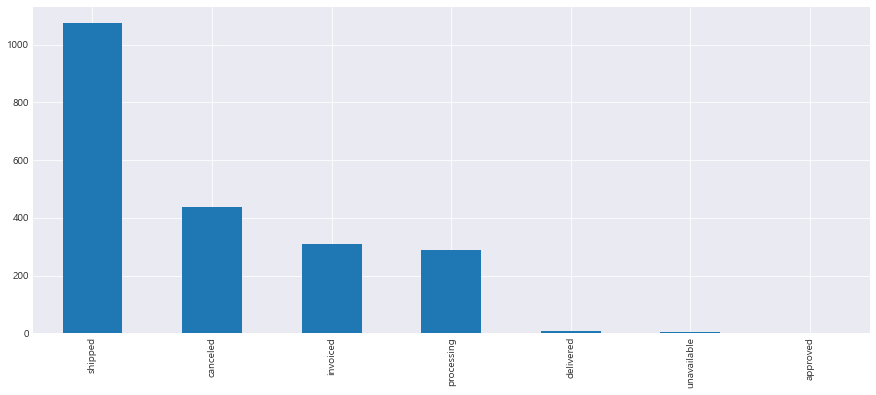

In [1513]:
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().plot.bar(figsize = (15,6))
print(f"total : {df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().sum()}")
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts()

**order_status == delivered인데  
(1)order_delivered_carrier_date  
(2)order_delivered_customer_date  
가 없는 관측치 제거**

In [1514]:
df_temp = df_temp[(df_temp.order_status!="delivered") | (df_temp.order_delivered_carrier_date.notnull()==True)]
df_temp = df_temp[(df.order_status!="delivered") | (df.order_delivered_customer_date.notnull()==True)]
df_temp.isnull().sum().sort_values(ascending = False)

review_comment_title             85429
review_comment_msg_en            56685
review_comment_message           56658
order_delivered_customer_date     2117
order_delivered_carrier_date       975
geolocation_lng_y                  263
customer_zip_code_prefix           263
customer_state                     263
geolocation_lat_y                  263
geolocation_lng_x                  212
geolocation_lat_x                  212
seller_state                       212
seller_zip_code_prefix             212
order_approved_at                   13
product_width_cm                     1
product_height_cm                    1
product_length_cm                    1
product_weight_g                     1
payment_value                        1
order_estimated_delivery_date        0
review_id                            0
review_score                         0
customer_unique_id                   0
review_creation_date                 0
review_answer_timestamp              0
order_id                 

### geolocation_zip_code_prefix 결측치 처리
***
- zip_code가 없는 고객 및 판매자 관측치는 제거

In [1515]:
df_temp = df_temp[(df_temp.seller_zip_code_prefix.notnull()) & (df_temp.customer_zip_code_prefix.notnull())]
# df_temp = df_temp[df_temp.seller_zip_code_prefix.notnull()]
df_temp.isnull().sum().sort_values(ascending = False)

review_comment_title             85010
review_comment_msg_en            56399
review_comment_message           56372
order_delivered_customer_date     2105
order_delivered_carrier_date       969
order_approved_at                   13
product_weight_g                     1
product_width_cm                     1
product_height_cm                    1
product_length_cm                    1
payment_value                        1
review_id                            0
review_score                         0
review_creation_date                 0
geolocation_lng_y                    0
geolocation_lat_y                    0
customer_state                       0
customer_zip_code_prefix             0
customer_unique_id                   0
order_estimated_delivery_date        0
review_answer_timestamp              0
order_id                             0
customer_id                          0
order_purchase_timestamp             0
order_status                         0
seller_id                

### order_approved_at 결측치 확인 => 불필요 (컬럼 삭제)
***
- 배송은 완료됐으나, order_approved_at 데이터 기입 누락 사항으로 확인
- order_approved_at 날짜가 불필요할 경우 해당 컬럼 삭제

In [1516]:
del df_temp["order_approved_at"]

In [1517]:
df_temp.isnull().sum().sort_values(ascending=False)

review_comment_title             85010
review_comment_msg_en            56399
review_comment_message           56372
order_delivered_customer_date     2105
order_delivered_carrier_date       969
payment_value                        1
product_width_cm                     1
product_height_cm                    1
product_weight_g                     1
product_length_cm                    1
review_id                            0
order_purchase_timestamp             0
review_score                         0
review_creation_date                 0
geolocation_lng_y                    0
geolocation_lat_y                    0
customer_state                       0
customer_zip_code_prefix             0
customer_unique_id                   0
order_estimated_delivery_date        0
review_answer_timestamp              0
order_id                             0
customer_id                          0
order_status                         0
product_description_lenght           0
seller_id                

### product_width & length & height_cm결측치 확인 => 불필요(컬럼 삭제)
***
- 하기 상품 정보 누락 확인
- 상품 규격이 불필요할 경우 해당 컬럼 삭제

In [1518]:
df_temp[df_temp.product_width_cm.isnull()==True]

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,year_month
85643,85f8ad45e067abd694b627859fa57453,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,1.0,1961.0,27.0,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN,baby,baby,86020.0,PR,-23.312601,-51.16718,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08,69b2b29382af03e03e486ad307a76000,90160.0,RS,-30.051007,-51.217957,1961.0,125af5098b160c059cd60bafcc1f6ad1,5,NaN,NaN,2017-02-08 0:00,2017-02-09 10:09,NaN,2017-01-01


In [1519]:
cols = ["product_length_cm","product_weight_g","product_height_cm","product_width_cm"]
df_temp = df_temp.drop(columns = cols,axis = 1).copy()
df_temp.isnull().sum().sort_values(ascending=False)

review_comment_title             85010
review_comment_msg_en            56399
review_comment_message           56372
order_delivered_customer_date     2105
order_delivered_carrier_date       969
payment_value                        1
review_creation_date                 0
review_score                         0
review_id                            0
product_id                           0
geolocation_lng_y                    0
geolocation_lat_y                    0
customer_state                       0
customer_zip_code_prefix             0
customer_unique_id                   0
order_estimated_delivery_date        0
review_answer_timestamp              0
order_id                             0
order_purchase_timestamp             0
order_status                         0
product_description_lenght           0
seller_id                            0
item_nb                              0
total_payment                        0
freight_value                        0
product_category_name    

### payment_value 결측치 확인 => total_payment 대체
***
- payment_value 값 자체가 오계산된 것을 확인하여 total_payment 대체

In [1520]:
tmp_items = olist_order_items.groupby("order_id").total_payment.sum().reset_index()

tmp = pd.merge(olist_order_payments,tmp_items,on="order_id")
tmp = tmp.groupby("order_id").agg({"payment_value" : "sum", "total_payment" : "mean"}).reset_index()
tmp[abs(tmp.payment_value-tmp.total_payment)>0.1]

,order_id,payment_value,total_payment
165,00789ce015e7e5791c7914f32bb4fad4,190.81,168.83
525,016726239765c18f66826453f39c64e3,265.77,235.13
724,01e51b7c3025655646143d09b911e1d7,35.02,33.10
965,028aa7c930356788f861ed1b7f984819,62.94,57.53
1123,02f4dd90ba0feb8ec394cac05862d2b5,141.65,130.96
...,...,...,...
96560,fa87437f971fce498b2184cd2401e23e,66.93,63.27
96713,faf132fb35b3b3b533a67efbd6e7c02d,130.01,115.02
97100,fbf352b18a26c6a86a53cca922facd25,160.80,151.54
97605,fd33085945f15975375cd8ec85440511,212.82,234.62


In [1521]:
olist_order_items[olist_order_items.order_id=="00789ce015e7e5791c7914f32bb4fad4"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment,freight_value_rate
185,00789ce015e7e5791c7914f32bb4fad4,1,f9d774a1820f792952eea079a40a7c6b,2709af9587499e95e803a6498a5a56e9,2017-07-04 23:43:34,154.0,14.83,168.83,0.08784


In [1522]:
df_temp = df_temp.drop(columns = ["payment_value"],axis = 1)

### 년분기별 판매 건수 확인 => 데이터셋 17.1~18.8로 축소
- 16.9, 16.12 매출건수가 매우 적으므로 해당 기간의 데이터를 분석하기엔 부적절하다고 판단됨

In [1523]:
df_temp.groupby("year_month").order_id.count()

year_month
2016-09-01       4
2016-10-01     311
2016-12-01       1
2017-01-01     775
2017-02-01    1686
2017-03-01    2610
2017-04-01    2320
2017-05-01    3558
2017-06-01    3131
2017-07-01    3844
2017-08-01    4164
2017-09-01    4152
2017-10-01    4470
2017-11-01    7322
2017-12-01    5478
2018-01-01    7000
2018-02-01    6439
2018-03-01    6992
2018-04-01    6819
2018-05-01    6767
2018-06-01    6052
2018-07-01    6133
2018-08-01    6344
Name: order_id, dtype: int64

In [1524]:
start_date = dt.date(2017,1,1)
end_date = dt.date(2018,9,1)
print(f"16.9~18.9 : {df_temp.shape}")
df_temp = df_temp[(df_temp.order_purchase_timestamp.dt.date >= start_date) &
                  (df_temp.order_purchase_timestamp.dt.date < end_date)].reset_index(drop=True)
print(f"17.1~18.8 : {df_temp.shape}")

16.9~18.9 : (96372, 35)
17.1~18.8 : (96056, 35)


# Feature Eng

## review_score 목표변수 컬럼 변경
---
review_score가 1,2,3 일 경우 1 / 4,5일 경우 0

In [1525]:
df_temp["review_score_binary"] = df_temp.apply(lambda x : 1 if x.review_score <= 3 else 0, axis = 1)

In [1526]:
df_temp.head(2)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,year_month,review_score_binary
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed.",2017-09-01,0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi...",2017-06-01,0


## 배송 속도, 기간, 배송 상품 준비 기간 컬럼 생성

In [1527]:
### 배송 지연 기간(완료일 - 예정일), 완료보다 오래 걸리면 1, 아니면 0
df_temp["delivery_delay"] = (df_temp.order_estimated_delivery_date -  df_temp.order_delivered_customer_date).dt.days
df_temp["delivery_delay_binary"] = df_temp.apply(lambda x : 1 if x.delivery_delay <= 0 else 1, axis = 1)

### 예정 배송 기간(구매~배송완료)
df_temp["delivery_periods"] = (df_temp.order_estimated_delivery_date -  df_temp.order_purchase_timestamp).dt.days

### 배송 준비 기간(구매~상품준비) #직전 3개월 컬럼 생성용
df_temp["delivery_preparation"] = (df_temp.order_delivered_carrier_date -  df_temp.order_purchase_timestamp).dt.days

## 특이 건수 비율 컬럼 생성
- 배송 완료일자가 예정일차를 초과한 경우 이상 건수로 판단

In [1528]:
#배송 기간이 구매~배송 완료기간을 초과한 경우 특이 판매 건수로 판단
df_temp["delivery_error"] = df_temp.apply(lambda x : 1 if x.delivery_delay <= 0 else 1, axis = 1)

#order_status가 cancel인 경우 error로 추가
df_temp.loc[df_temp.order_status=="canceled","cancel"]=1
df_temp["cancel"] = df_temp.cancel.fillna(0)

In [1529]:
df_temp.head(2)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,year_month,review_score_binary,delivery_delay,delivery_delay_binary,delivery_periods,delivery_preparation,delivery_error,cancel
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed.",2017-09-01,0,8.0,1,15,6.0,1,0.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi...",2017-06-01,0,12.0,1,27,7.0,1,0.0


## 판매자 등급 컬럼 생성

**네이버 등급 기준**  
참고1 : http://blog.naver.com/PostView.nhn?blogId=hddong&logNo=221177199866  
참고2 : https://m.blog.naver.com/ulf22se/221833193818
***
- 판매자 등급 : 씨앗 > 새싹 > 파워 > 빅파워 > 프리미엄 > 플래티넘  
- 등급 산정 기준 : 최근 3개월 누적 데이터, 구매확정 기준(배송비 제외)
- 업데이트 주기 : 매월 2일, 판매자 등급별 한도수 부여
- 이미 초과한 경우 상품이 삭제되진 않으나, 신규 등록 및 일괄 등록 제한
- 굿서비스
    - 산정 기간 : 최근 1개월 데이터
    - 굿서비스 업데이트 주기 : 매월 2일
    - 산정 기준
        1. 구매평 만족 : 구매평 평균 만족 90% 이상
        2. 빠른 배송 : 48시간 이내 배송완료가 전체 배송건수의 80% 이상
        3. 고객문의 1일 이내 응답이 90%이상
        4. 판매 건수 : 20건 이상(구매 확정 기준)
    

|등급|등급명|판매건수|판매금액|굿서비스|상품등록한도|  
|----|------|--------|--------|--------|------------|
|1|프리미엄|2000건이상|6억원 이상|필수|50만개|
|2|빅파워|500건이상|4천만 이상||50만개
|3|파워|300건이상|800만원 이상||30만개
|4|새싹|100건이상|200만원 이상||10만개
|5|씨앗|100건미만|200만원 미만||1만개


- 상품의 품절로 인해 주문취소가 발생할 경우 패널티가 부과되어, 건별 2점(1%) 패널티 부과
    - 참고 : https://ips.smartstore.naver.com/main/rules/safety/credit
- 파워 이상은 등급에 따른 아이콘 노출됨
- 굿 서비스 충족 시 아이콘 옆에 굿서비스 아이콘 생성
- 특정 조건 만족 시 성장포인트 지급
- 스타트 스토어 특정기준 충족 시 12개월 제로수수료 서비스 제공

### 직전 3개월 배송준비기간, 배송지연기간, 에러율 컬럼 생성

In [1530]:
#seller & year_month expand.grid
seller_id_list = df_temp.seller_id.unique().tolist()

#전체 년월은 17.1~18.8이지만 직전 3개월 매출액 및 건수 컬럼을 추가하기 위해 범체 범위의 전후 1개월 추가
year_month_list = pd.date_range(start = "20170101" ,end = "20180801", freq = "MS")
seller_YearMonth = pd.DataFrame(np.array([(x,y) for x in seller_id_list for y in year_month_list]))\
                   .rename(columns = {0 : "seller_id", 1 : "year_month"})
seller_YearMonth["year_month"]=seller_YearMonth.year_month.dt.date
seller_YearMonth.shape

(59520, 2)

In [1531]:
#등급 생성 및 직전 3개월 평균 데이터 컬럼 생성용 함수 만들기
def cal_columns_rolling(df, groupby_cols, agg_cols, agg_method):

    #groupy 기준에 따라 집계한 컬럼 합치기   
    df_temp = df.copy()
    for i, col in enumerate(agg_cols):
        if i == 0:
            tmp = df_temp.groupby(groupby_cols).agg({col : agg_method}).reset_index()
        else:
            others = df_temp.groupby(groupby_cols).agg({col : agg_method}).reset_index()
            tmp = tmp.merge(others, on = groupby_cols)
    
    #seller별 첫 판매월 및 마지막 판매월 컬럼 생성
    tmp["start_YearMonth"] = tmp.groupby("seller_id").year_month.transform("min")
    tmp["end_YearMonth"] = tmp.groupby("seller_id").year_month.transform("max")

    #seller별로 첫 팟매월과 마지막 판매월 사이 비어있는 월 인덱스를 추가하기 위한 데이터셋 생성
    rolling_cols = groupby_cols.copy()
    rolling_cols.remove("year_month")
    seller_start_end_yearmonth = tmp[rolling_cols + ["start_YearMonth","end_YearMonth"]].drop_duplicates(ignore_index = True)
    seller_start_end_yearmonth_selected = seller_start_end_yearmonth.merge(seller_YearMonth)

    #seller별로 첫 첫 판매 월부터 마지막 판매월 사이의 월 인덱스만 남기기
    cond = (seller_start_end_yearmonth_selected.year_month >= seller_start_end_yearmonth_selected.start_YearMonth) \
          &(seller_start_end_yearmonth_selected.year_month <= seller_start_end_yearmonth_selected.end_YearMonth)

    seller_start_end_yearmonth_selected = seller_start_end_yearmonth_selected[cond]

    tmp = tmp.merge(seller_start_end_yearmonth_selected,
                    on = groupby_cols+['start_YearMonth','end_YearMonth'], how = "right")
    tmp = tmp.drop(["start_YearMonth","end_YearMonth"], axis=1)

    # #컬럼별 직전 3개월 합계 값 컬럼 생성
    for var in (agg_cols + count_cols):
        tmp[var+"_rolling"] = tmp.groupby(rolling_cols)[var]\
                                        .transform(lambda x: x.rolling(window = 3,min_periods=1).sum())

    # 불필요한 컬럼 제거
    tmp = tmp.drop((agg_cols + count_cols), axis=1)

    # 3개월치 집계한 rolling 결과는 다음 월에 대한 값이므로 month = +1
    tmp["year_month"] = tmp["year_month"] + relativedelta(months=+1)

    # 전체 데이터셋에서 년월 & seller별 관측치가 있는 경우의 row만 남기기
    seller_yearmonth_list = df_temp.groupby(groupby_cols).agg({agg_cols[0] : "count"}).reset_index().drop(agg_cols[0],axis=1)
    tmp = tmp.merge(seller_yearmonth_list, on = groupby_cols, how = "right")
    return tmp

In [1532]:
df_temp2 = df_temp.copy()

#직전 3개월 배송준비기간, 배송지연기간, 에러율
rolling = cal_columns_rolling(df = df_temp2[df_temp2.order_status=="delivered"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["delivery_preparation","delivery_delay","delivery_error"],
                    agg_method= "sum")

counting = cal_columns_rolling(df = df_temp2[df_temp2.order_status=="delivered"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["order_id"],
                    agg_method= "count").rename(columns = {"order_id_rolling" : "counting_rolling"})

rolling = rolling.merge(counting, on = ["seller_id","year_month"])

In [1533]:
df_temp2 = df_temp2.merge(rolling, on = ["seller_id","year_month"], how = "left").copy()

### 직전 3개월 취소율 컬럼 생성

In [1534]:
df_temp3 = df_temp2.copy()
cancel_error_rate = cal_columns_rolling(df = df_temp3[df_temp3.order_status == "canceled"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["cancel"],
                    agg_method = "sum")

#에러가 없는 경우(nan) 0으로 대체
# cancel_error_rate = cancel_error_rate.fillna(0)

#직전 3개월 전체 관측치 중 에러율을 구하기 위해 관측치 count 컬럼 생성

counting_all = cal_columns_rolling(df = df_temp3,
                               groupby_cols = ["seller_id","year_month"],
                               agg_cols = ["order_id"],
                               agg_method = "count").rename(columns = {"order_id_rolling" : "counting_all_rolling"})

cancel_error_rate = cancel_error_rate.merge(counting_all, on = ["seller_id","year_month"])

In [1535]:
#merge
df_temp3 = df_temp3.merge(cancel_error_rate, on = ["seller_id","year_month"], how = "left").copy()

In [1537]:
#직전 3개월 최소율
df_temp3["cancel_rate_rolling"] = \
df_temp3["cancel_rolling"]/(df_temp3["counting_all_rolling"])

#직전 3개월 에러율
df_temp3["delivery_error_rate_rolling"] = \
df_temp3["delivery_error_rolling"] / df_temp3["counting_rolling"]

#직전 3개월 배송 준비기간
df_temp3["delivery_preparation_rolling"] = \
df_temp3["delivery_preparation_rolling"] / df_temp3["counting_rolling"]

#직전 3개월 배송 지연기간
df_temp3["delivery_delay_rolling"] = \
df_temp3["delivery_delay_rolling"] / df_temp3["counting_rolling"]


In [1539]:
df_temp3.head(2)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,year_month,review_score_binary,delivery_delay,delivery_delay_binary,delivery_periods,delivery_preparation,delivery_error,cancel,delivery_preparation_rolling,delivery_delay_rolling,delivery_error_rolling,counting_rolling,cancel_rolling,counting_all_rolling,cancel_rate_rolling,delivery_error_rate_rolling
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed.",2017-09-01,0,8.0,1,15,6.0,1,0.0,2.894737,9.385965,57.0,57.0,NaN,NaN,NaN,1.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,cool_stuff,58.0,598.0,4.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi...",2017-06-01,0,12.0,1,27,7.0,1,0.0,3.434783,12.869565,23.0,23.0,NaN,NaN,NaN,1.0


In [919]:
selected_columns = ['review_score','low_review_score_rate','year_month', 'seller_id','rating','product_category_upper',
                    'seller_state','seles_by_OrderNumber','sales','order_nb',
                    'delivery_delay_new', 'delivery_periods_new','delivery_preparation_new',
                    'error_rate_based_on_CI','error_rate_based_on_estimated',
                    'rate_canceled',"canceled_rate_rolling","error_rate_based_on_CI_rolling","error_rate_based_on_estimated_rolling"]
df_model3 = df_model3[selected_columns]
df_model3.to_excel("df_model_new.xlsx",index = False)

# ----------------- 여기까지,,, 이 밑은.. 지옥이야 ---------------------

<AxesSubplot:xlabel='review_score', ylabel='Density'>

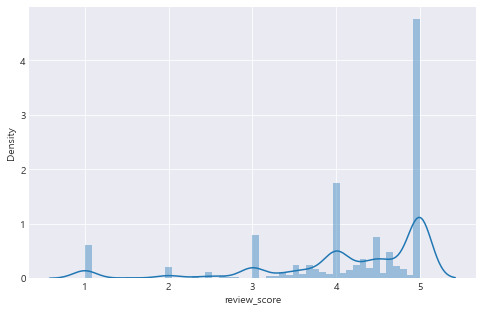

In [677]:
plt.figure(figsize = (8,5))
sns.distplot(df_model["review_score"])
# sns.distplot(np.log1p(df_model[df_model.order_nb >=(10)].review_score))



<AxesSubplot:xlabel='year_month', ylabel='delivery_delay'>

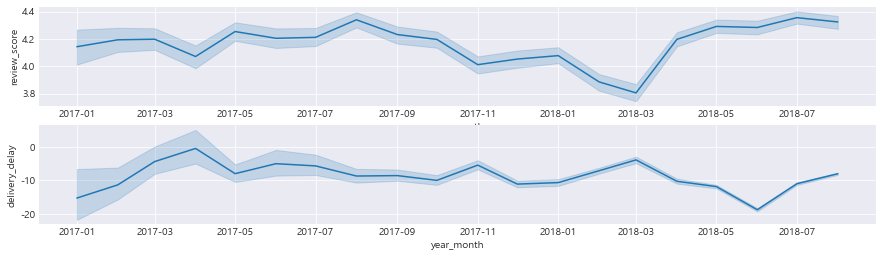

In [681]:
fig,ax = plt.subplots(2,1,figsize = (15,4))
sns.lineplot(data = df_model_temp2, x = "year_month", y = "review_score",ax= ax[0])

sns.lineplot(data = df_model_temp2, x = "year_month", y = "delivery_delay",ax= ax[1])

# 올리스트  
https://olist.com/planos/  &  https://olist.com/olist-store/  
https://get.olist.help/pt-BR/  
https://olist.com/faq/  
https://get.olist.help/pt-BR/articles/4856992-entenda-as-regras-de-comissionamento-e-frete-do-olist?_ga=2.59369453.1929511018.1614513656-1149340093.1613391697&_gac=1.93819375.1614091708.Cj0KCQiA7NKBBhDBARIsAHbXCB52_N1uIqfvjUSgGFhOgCrMvjl6iK7mDC-beGNnp_TZeSNo6BPe4CIaAncwEALw_wcB
- 올리스트는 마켓 플레이스 자체는 아니고, 하나의 백화점 형태이다. 올리스트 플랫폼에서도 제품을 판매하지만, 아마존, 아메라카나스, 줌 등 브라질의 다양한 마켓플레이스에서 상품을 판매 및 광고 등의 활동을 할 수 있도록 제공
- 올리스트 마켓 플레이스 판매자 등록비용 : 초기 계약 시 1회만 지불 
    - 제품당 커미션 부과 : 19~21%
    - 100달러 미만 : 고객이 배송비 100%부담, 판매자는 품목당 R$5dml 수수료 부담, 100달러 이상 : 정해진 테이블에 따라 판매자 및 올리스트가 나눠서 배송비 부담
    - 올리스트 스토어에서 수수료는 따로 부과하지 않고, 판매된 제품의 가치에 따른 수수료만 부담

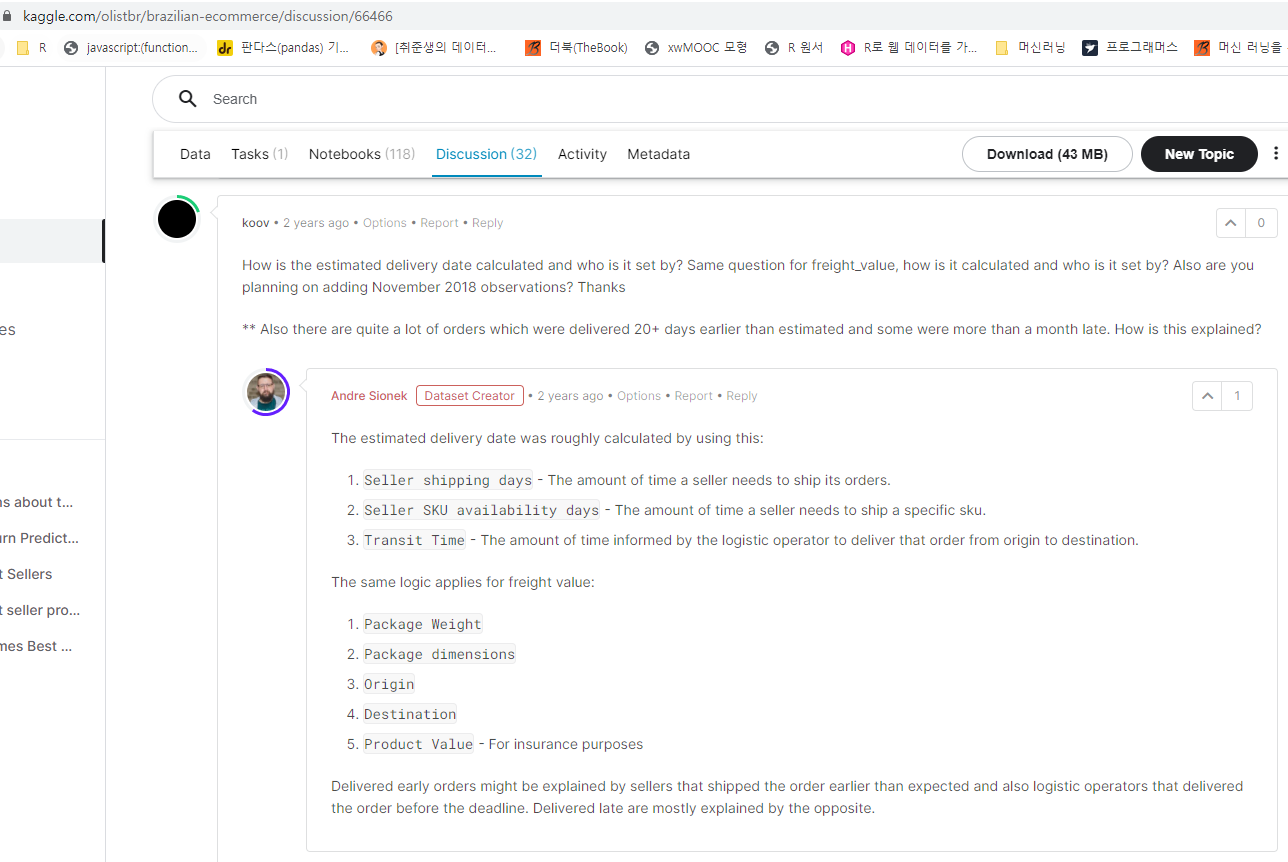

# EDA

## 판매자 기준

### 매출 총액

Text(0.5, 1.0, '판매자별 매출 총액 분포 log scale')

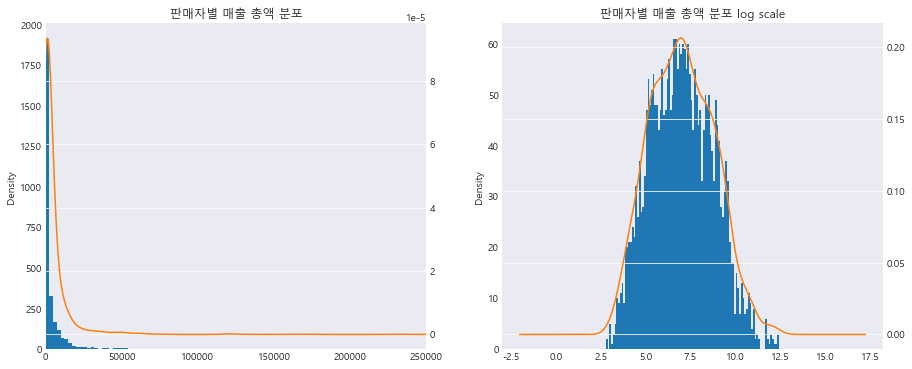

In [150]:
seller_sales_sum_mean = df_model3.groupby("seller_id").sales.agg(["sum"])
fig,ax = plt.subplots(1,2,figsize = (15,6))
seller_sales_sum_mean["sum"].plot.hist(bins = 100,ax=ax[0])
g = seller_sales_sum_mean["sum"].plot.kde(secondary_y = True,ax = ax[0])
g.set_title("판매자별 매출 총액 분포")
g.set_xlim(0,250000)

seller_sales_sum_mean["sum"].apply(np.log1p).plot.hist(bins = 100,ax=ax[1])
g1 = seller_sales_sum_mean["sum"].apply(np.log1p).plot.kde(secondary_y = True,ax = ax[1])
g1.set_title("판매자별 매출 총액 분포 log scale")

### 년분기별 매출 총액 cat

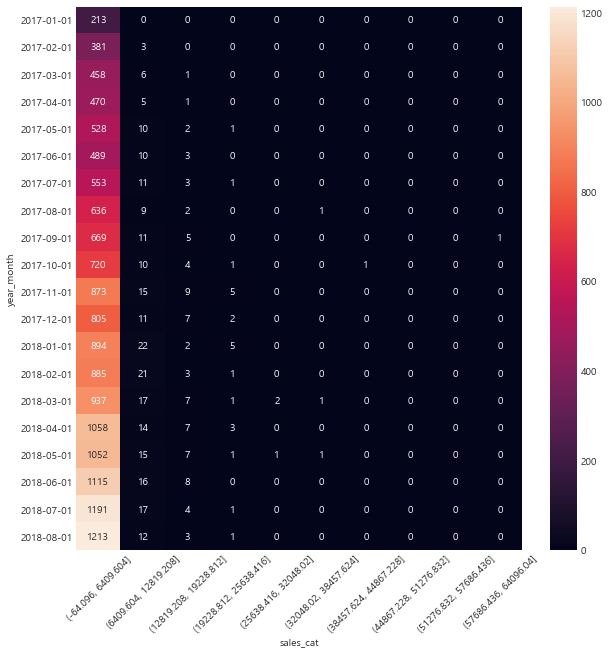

In [151]:
seller_sales_year_month = df_model3.groupby(["seller_id","year_month"]).sales.sum().reset_index()
seller_sales_year_month["sales_cat"] = pd.cut(x = seller_sales_year_month.sales,bins = 10)

temp = seller_sales_year_month.groupby(["year_month","sales_cat"]).seller_id.count().unstack()

fig,ax = plt.subplots(1,1,figsize = (10,10))
sns.heatmap(temp,annot = True, fmt = ".0f", ax = ax)
plt.xticks(rotation = 45)
plt.show()
# g.set_xticklabels(temp.columns, rotation = 45)

###  년분기별 매출총액 및 매출건수

In [152]:
df_model3.groupby(["seller_id","year_month"]).sales.sum().reset_index()

,seller_id,year_month,sales
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-01,916.02
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-01,1832.04
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02-01,1295.40
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03-01,2124.00
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04-01,2068.69
...,...,...,...
15479,fffd5413c0700ac820c7069d66d98c89,2018-05-01,1671.34
15480,fffd5413c0700ac820c7069d66d98c89,2018-06-01,365.44
15481,fffd5413c0700ac820c7069d66d98c89,2018-07-01,389.94
15482,fffd5413c0700ac820c7069d66d98c89,2018-08-01,624.33


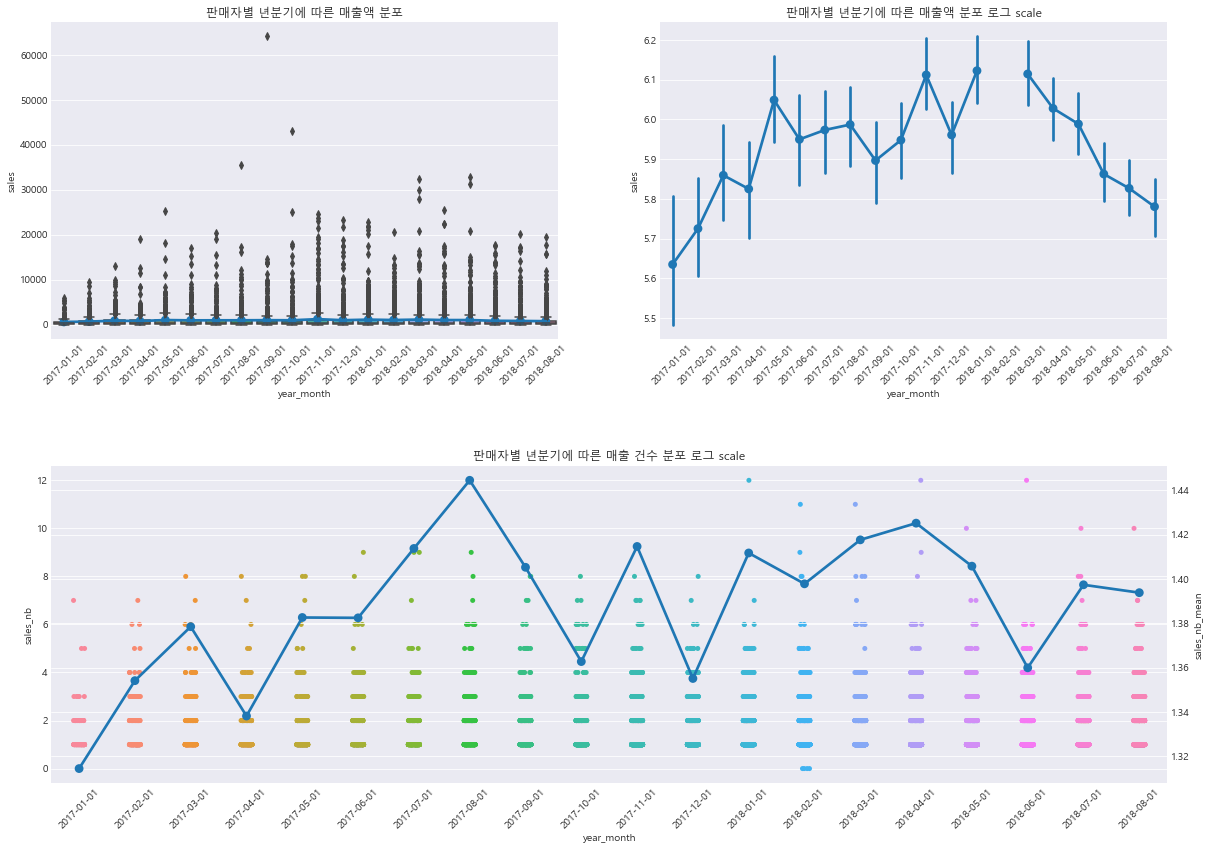

In [154]:
seller_sales = df_model3.groupby(["year_month","seller_id"]).sales.sum().reset_index()
seller_sales_log = seller_sales.copy()
seller_sales_log["sales"]=seller_sales_log["sales"].apply(np.log)

seller_sales_nb = df_model3.groupby(["year_month","seller_id"]).sales.count().reset_index().rename(columns = {"sales" : "sales_nb"})
seller_sales_nb_mean = seller_sales_nb.groupby("year_month").sales_nb.mean().reset_index().rename(columns = {"sales_nb":"sales_nb_mean"})
plt.figure(figsize = (20,14))
#sales 
plt.subplot(221)
sns.boxplot(data = seller_sales, x = "year_month", y = "sales")
sns.pointplot(data = seller_sales, x = "year_month", y = "sales")
plt.xticks(rotation = 45)
plt.title("판매자별 년분기에 따른 매출액 분포")

#sales log scale
plt.subplot(222)
# sns.violinplot(data = seller_sales_log, x = "year_month", y = "sales")
sns.pointplot(data = seller_sales_log, x = "year_month", y = "sales")
plt.xticks(rotation = 45)
plt.title("판매자별 년분기에 따른 매출액 분포 로그 scale")

plt.subplot(212)
ax = sns.stripplot(data = seller_sales_nb, x = "year_month", y = "sales_nb")
ax_twinx = ax.twinx()
sns.pointplot(data = seller_sales_nb_mean, x = seller_sales_nb_mean.year_month.astype(str), y = "sales_nb_mean",ax=ax_twinx)
labels = ax.axes.get_xticklabels()
ax.axes.set_xticklabels(labels, rotation=45)
plt.title("판매자별 년분기에 따른 매출 건수 분포 로그 scale")

plt.subplots_adjust(hspace = 0.4)
plt.show()

### 판매자별 판매상품 개수

<AxesSubplot:ylabel='product_category_upper'>

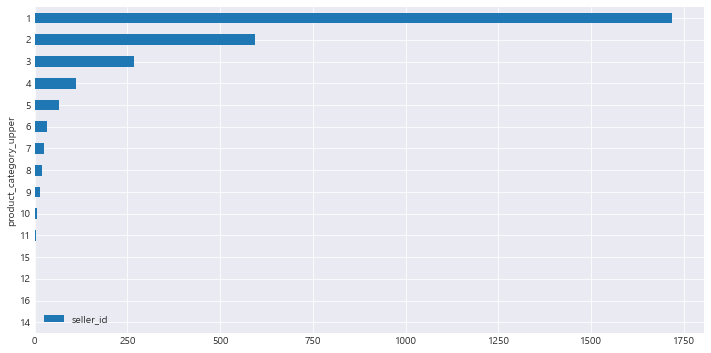

In [156]:
seller_cat_nb = df_model3[["seller_id","product_category_upper"]].drop_duplicates(ignore_index=True)
seller_cat_nb = seller_cat_nb.groupby("seller_id").count().reset_index().groupby("product_category_upper").count()

seller_cat_nb.sort_values("seller_id").plot.barh(figsize = (12,6))

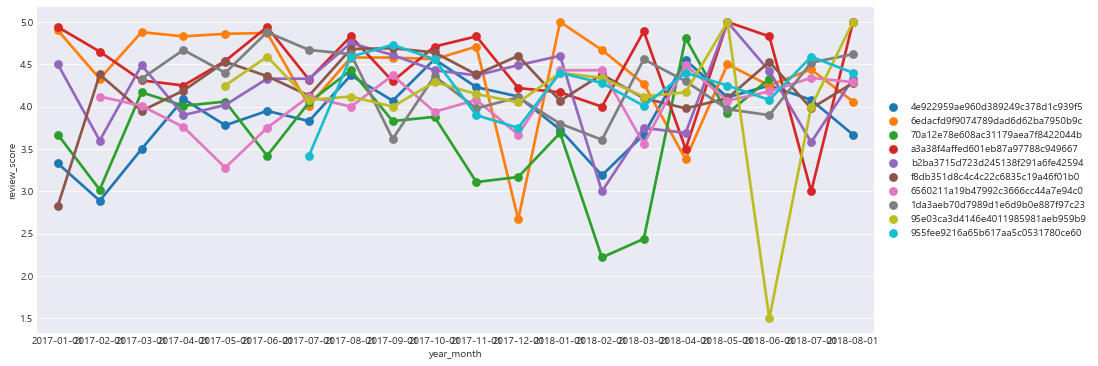

In [158]:
#상품 판매 건수가 많은 상위 10명의 판매자
seller_review_score = df_model3.groupby(["seller_id"]).review_score.agg(["mean","count"]).reset_index()
seller_top10_list = seller_review_score.sort_values("count", ascending = False).head(10).seller_id.tolist()

seller_top10_review_mean = df_model3[df_model3.seller_id.isin(seller_top10_list)].groupby(["year_month","seller_id"]).review_score.mean().reset_index().round(2)
plt.subplots(figsize = (15,6))
# seller_top10_review_mean
sns.pointplot(data = seller_top10_review_mean, x="year_month",y="review_score",hue = "seller_id")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**판매자에 따라 특정 기간에 고객이 없는 경우도 있음  
**


df_graph.order_purchase_timestamp.map(lambda x : dt.datetime(x.year,x.month,1)).dt.date